<h1>KMeans</h1>

In [1]:
from abc import ABC, abstractmethod

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons

from IPython.display import HTML
plt.style.use('ggplot')
%matplotlib inline

In [2]:
class BaseKMeans(ABC):
    def __init__(self, k, tol=1e-4):
        self.k = k
        self.centroids = None
        self.tol = tol
        
    @staticmethod
    def _euclidean_distance(x, y):
        if len(x.shape) == len(y.shape) == 1:
            axis = None
        else:
            axis = 1
        return np.sqrt(np.sum((x - y)**2, axis=axis))
    
    def init_centroids(self, x):
        """
        KMeans++ initialization, counting squared distances to closest cluster and use it as a probability
        of choosing new cluster
        """
        self.centroids = {}
        self.centroids[0] = x[np.random.choice(len(x), replace=False)]
        for i in range(1, self.k):
            preds = self.predict(x)  # find closest clusters for each x_i in X
            d2s = np.zeros(shape=(len(x), 1))
            
            for centr in self.centroids.keys():  # for each unique cluster
                c = self.centroids[centr]  # cluster coordinates
                subset = x[preds==centr]  # points of this cluster
                d2 = self._euclidean_distance(subset, c)**2  # distance from each object to centroid
                d2s[preds==centr] = d2.reshape(-1, 1)

            p = d2s / sum(d2s)  # use it as a probability
            centroid = x[np.random.choice(len(x), p=p.ravel())]
            self.centroids[i] = centroid
    
    @abstractmethod
    def fit(self, x):
        pass
    
    def _distances_with_cluster(self, x):
        centroids_keys = self.centroids.keys()  # unique centroids
        distances = np.zeros(shape=(len(x), len(centroids_keys)))  # here we store distances
        
        for centr in centroids_keys:  # for each centroid
            dist = self._euclidean_distance(self.centroids[centr], x)  # count distance for each centroid to each point
            distances[:, centr] = dist
            
        clusters = np.argmin(distances, axis=1).reshape(-1, 1)  # find closest centroid for each point
        distances_w_cl = np.hstack((distances, clusters))  # distances with centroids
        return distances_w_cl
    
    def predict(self, x):
        distances_w_cl = self._distances_with_cluster(x)
        return distances_w_cl[:, -1]
    
    def __repr__(self):
        return f'KMeans(k={self.k})'

class KMeans(BaseKMeans):    
    def fit(self, x, n_iter=100):
        self.init_centroids(x)
            
        for _ in range(n_iter):
            distances_w_cl = self._distances_with_cluster(x)
            
            stopping_indicator = 0
            for centr in self.centroids.keys():  # for each cluster
                slice_idx = distances_w_cl[:, -1] == centr  # choose only points from this cluster
                new_centr = x[slice_idx].mean(axis=0)  # new centroid coordinates
                if self._euclidean_distance(self.centroids[centr], new_centr) <= self.tol:
                    stopping_indicator += 1
                self.centroids[centr] = new_centr
                
            if stopping_indicator == self.k:  # if all of the centroids didn't changed
                print(f'Early stopping, n = {_}')
                break
        return self
    
class MiniBatchKmeans(BaseKMeans):
    def __init__(self, k, tol=1e-4, batch_size=32):
        super().__init__(k, tol)
        self.batch_size = batch_size
        
    def fit(self, x, n_iter=100):
        self.init_centroids(x)
            
        for _ in range(n_iter):
            batch_idx = np.random.choice(len(x), size=self.batch_size, replace=False)
            batch = x[batch_idx]
            distances_w_cl = self._distances_with_cluster(batch)
            
            stopping_indicator = 0
            for centr in self.centroids.keys():
                slice_idx = distances_w_cl[:, -1] == centr
                new_centr = batch[slice_idx].mean(axis=0)
                if self._euclidean_distance(self.centroids[centr], new_centr) <= self.tol:
                    stopping_indicator += 1
                self.centroids[centr] = new_centr
                
            if stopping_indicator == self.k:
                print(f'Early stopping, n = {_}')
                break
        return self

In [3]:
x, y = make_blobs(1000, random_state=10, centers=5)

In [4]:
def plot_clusters(estimator, x):
    preds = estimator.predict(x)

    plt.figure(figsize=(12, 8))
    plt.scatter(x[:, 0], x[:, 1])
    for centr in estimator.centroids.keys():
        plt.scatter(x[preds==centr][:, 0], x[preds==centr][:, 1])
        plt.scatter(estimator.centroids[centr][0], estimator.centroids[centr][1], s=200)

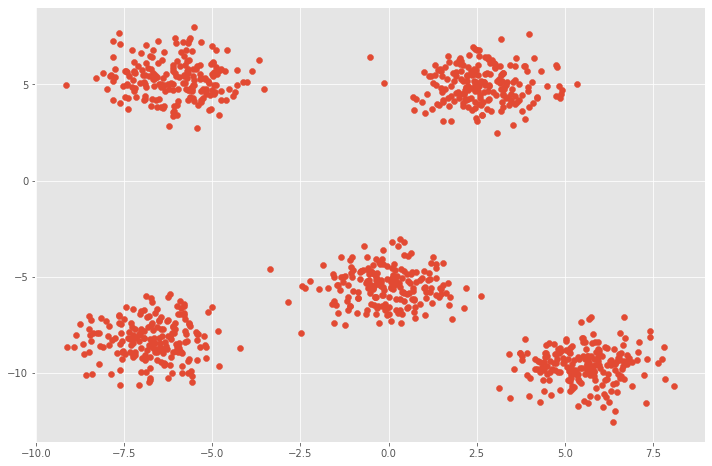

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(x[:, 0], x[:, 1])

In [6]:
kmeans = KMeans(5)

In [7]:
%%time
kmeans.fit(x, 1000)

Early stopping, n = 5
Wall time: 19.9 ms


KMeans(k=5)

In [8]:
kmeans.centroids

{0: array([-6.06306977,  5.27685104]),
 1: array([ 5.55389732, -9.61891479]),
 2: array([-0.07378228, -5.50370058]),
 3: array([-6.73474199, -8.29170239]),
 4: array([2.64004968, 4.96083603])}

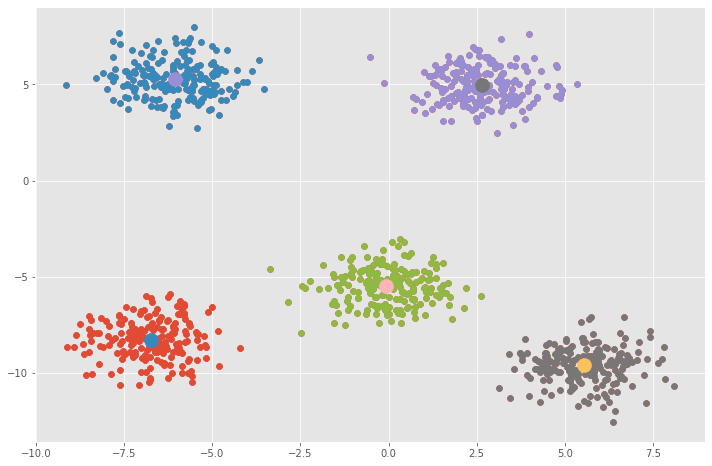

In [9]:
plot_clusters(kmeans, x)

In [10]:
minibatchkmeans = MiniBatchKmeans(5, batch_size=len(x) // 3)

In [11]:
%%time
minibatchkmeans.fit(x, 1000)

Wall time: 1.27 s


KMeans(k=5)

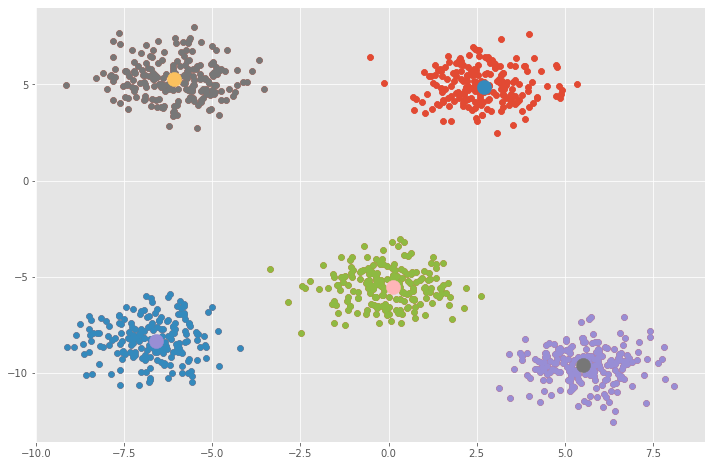

In [12]:
plot_clusters(minibatchkmeans, x)

In [13]:
def elbow_distances(x, k_min=1, k_max=10, plot=False):
    distances = []
    
    for k in range(k_min, k_max):  # check different k
        estimator = KMeans(k)
        estimator.fit(x)

        preds = estimator.predict(x)
        dists = []
        for centr in estimator.centroids.keys():  # for each centroid
            c = estimator.centroids[centr]  # centroid coordinates
            subset = x[preds==centr]  # find points for current centroid
            dist = estimator._euclidean_distance(subset, c)**2  # find distance is square from each point to its centroid
            dists.append(dist.sum())  # and sum it for each point in cluster
        distances.append(np.sum(dists))  # sum it for every cluster
        
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(range(k_min, k_max), distances)
        plt.xlabel('K')
        plt.ylabel('SSE')
        plt.xticks(range(k_min, k_max))
        plt.grid(True)
        plt.show()
    return distances

Early stopping, n = 1
Early stopping, n = 1
Early stopping, n = 10
Early stopping, n = 4
Early stopping, n = 1
Early stopping, n = 7
Early stopping, n = 11
Early stopping, n = 21
Early stopping, n = 9


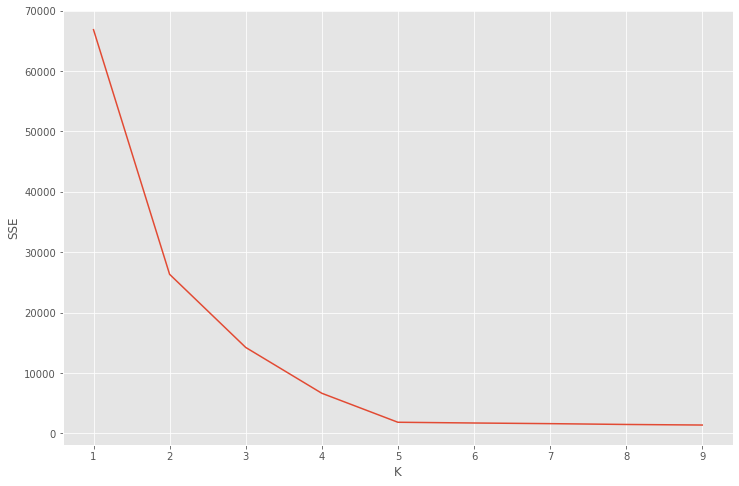

[66831.59663858893,
 26345.401133992433,
 14244.550576451229,
 6660.135220649238,
 1859.7022504249962,
 1736.2259346509704,
 1629.1262244741895,
 1494.842541885324,
 1399.9920282521712]

In [14]:
elbow_distances(x, 1, 10, True)

In [15]:
x_moons, y_moons = make_moons(1000, noise=0.05)

Early stopping, n = 6


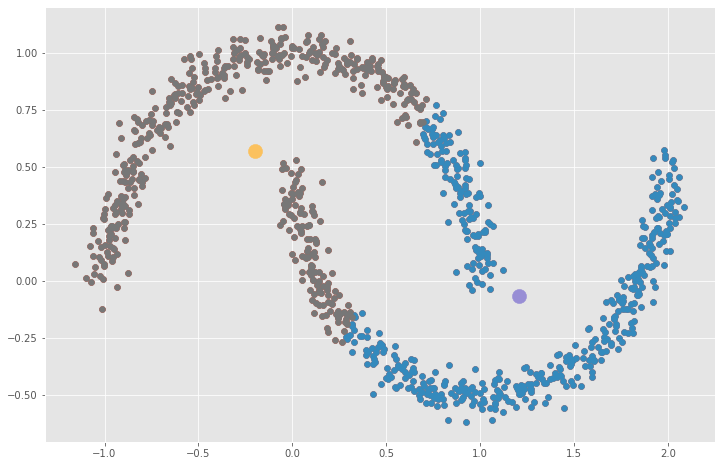

In [16]:
kmeans_moons = KMeans(2)
kmeans_moons.fit(x_moons)
plot_clusters(kmeans_moons, x_moons)

Early stopping, n = 1
Early stopping, n = 8
Early stopping, n = 15
Early stopping, n = 22
Early stopping, n = 26
Early stopping, n = 25
Early stopping, n = 13
Early stopping, n = 19
Early stopping, n = 29


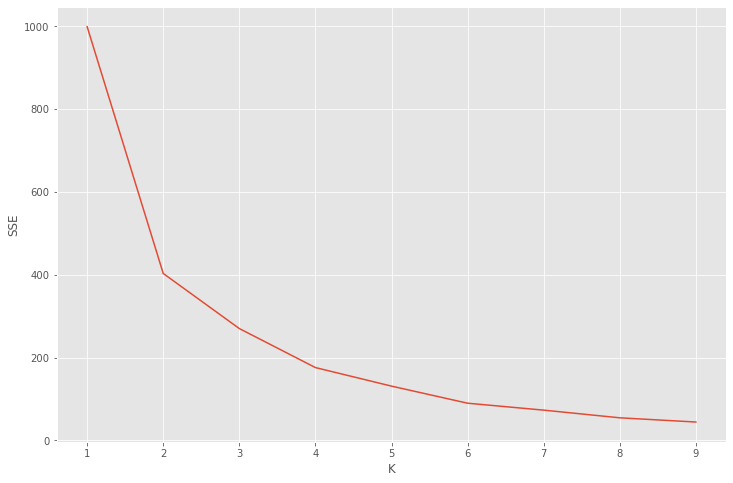

[999.1177291949393,
 403.0377326436021,
 269.96011506345025,
 175.70647419172118,
 130.90000741221166,
 89.63440005373997,
 72.8751150637808,
 54.36358487015918,
 44.15398055328912]

In [17]:
elbow_distances(x_moons, plot=True)

In [18]:
def silhouette(estimator, x):
    
    def find_closest_centroid(current_centroid):
        """
        Function that helps to find closest centroid, not the same
        """
        closest_centroid = None
        best_distance = np.inf
        for centr, coords in estimator.centroids.items():  # for each centroid and its coordinates
            distance = estimator._euclidean_distance(current_centroid, coords)  # count distance from our centroid to current
            if distance < best_distance and distance > 0:  # check if it's the best, the closest
                closest_centroid = centr
                best_distance = distance
                
        if closest_centroid is None:
            closest_centroid = 0  # it happens when there is only one centroid
            
        return closest_centroid
    
    preds = estimator.predict(x)
    
    silhouettes = []  # we need to count it for every point in dataset
    for centr in estimator.centroids.keys():  # for each centroid
        c = estimator.centroids[centr]
        subset = x[preds==centr]  # choose points from current cluster
        
        for elem in subset:  # for each point from current cluster
            closest_centr = find_closest_centroid(c)  # find closest cluster
            closest_c = estimator.centroids[closest_centr]
            closest_subset = x[preds==closest_centr]  # and points from closest cluster
            
            distance_in_cluster = estimator._euclidean_distance(elem, subset)  # count distance to every point in current cluster
            distance_in_cluster.sort()  # sort it
            a = distance_in_cluster[1:].mean()  # we don't need the first, in case it's the same point as elem
            b = estimator._euclidean_distance(elem, closest_subset).mean()  # mean distance to each point in the closest cluster
            silhouette_value = (b - a) / np.max([a, b])  # silhouette value
            
            silhouettes.append(silhouette_value)
            
    return np.array(silhouettes)

def silhouette_method(x, k_min=1, k_max=10, plot=False):
    silhouettes = []
    
    for k in range(k_min, k_max):
        estimator = KMeans(k)
        estimator.fit(x)
        
        silhouette_value = silhouette(estimator, x)
        silhouettes.append(np.mean(silhouette_value))
        
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(range(k_min, k_max), silhouettes)
        plt.xlabel('K')
        plt.ylabel('SSE')
        plt.xticks(range(k_min, k_max))
        plt.grid(True)
        plt.show()
        
    return silhouettes

Early stopping, n = 1
Early stopping, n = 1
Early stopping, n = 1
Early stopping, n = 10
Early stopping, n = 10
Early stopping, n = 4
Early stopping, n = 14
Early stopping, n = 8
Early stopping, n = 9


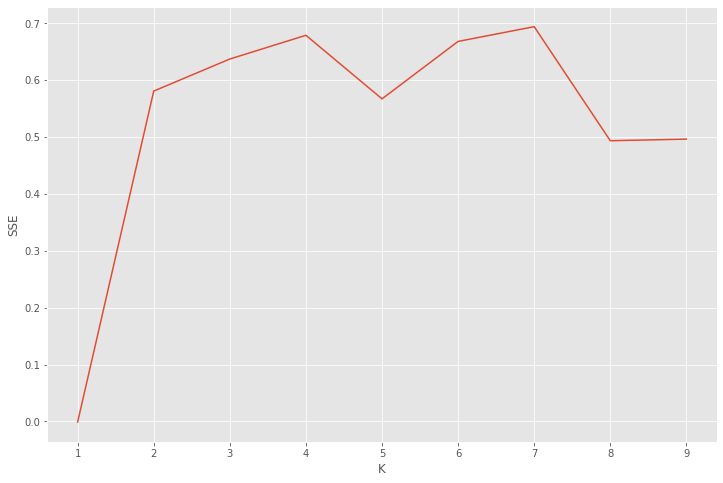

[-0.000999999999999994,
 0.5808652526402331,
 0.6372033121757086,
 0.6789391421418006,
 0.5671709010396829,
 0.6681673350529314,
 0.6940570832253159,
 0.4935727127413048,
 0.4963819795865542]

In [19]:
silhouette_method(x, plot=True)

In [20]:
def plot_silhouette(silhouette_values, preds):
    sorteds = []
    for cl in np.unique(preds):
        idx = np.where(preds == cl)[0]
        sub_silhs = silhouette_values[idx]
        sub_silhs.sort()
        sorteds.append(sub_silhs[::-1])
        
    k = np.max(preds) + 1
    mean_value = silhouette_values.mean()
    plt.figure(figsize=(12, 8))
    sns.barplot(np.concatenate(sorteds).ravel(), list(range(len(preds))), orient='h')
    plt.axvline(mean_value, ls='--', color='black', lw=2)
    plt.yticks([])
    plt.xlabel('Silhouette')
    plt.title(f'k = {k}, {mean_value}')
    plt.show()

Early stopping, n = 1


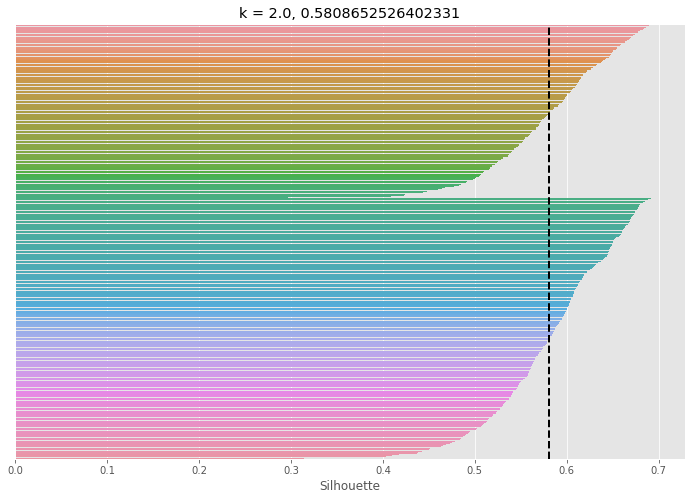

Early stopping, n = 2


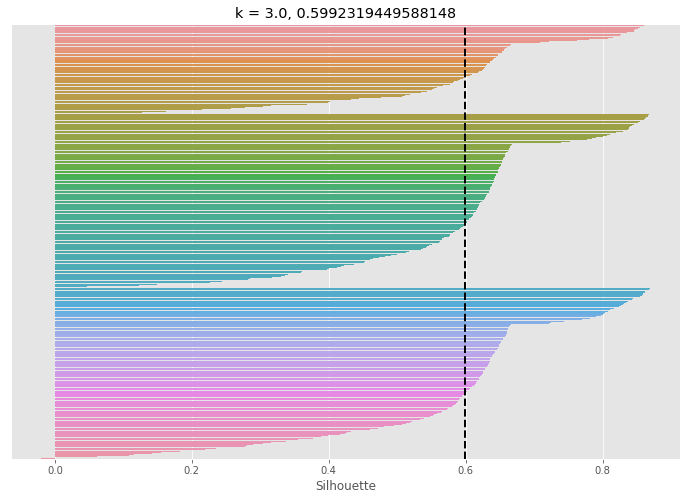

Early stopping, n = 2


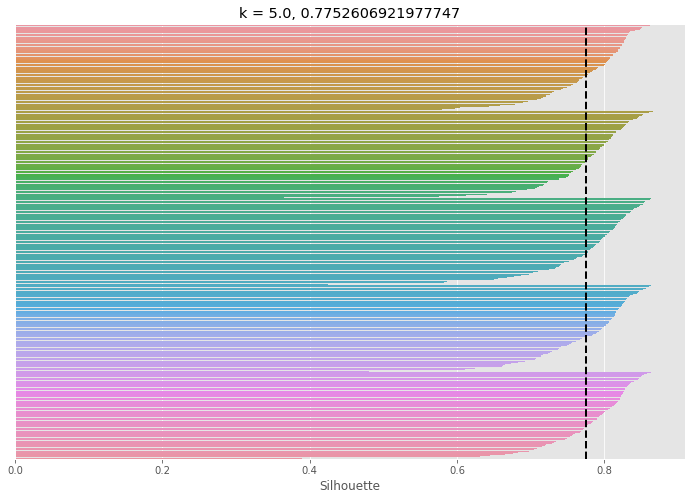

Wall time: 31.6 s


In [26]:
%%time
for k in [2, 3, 5]:
    kmeans = KMeans(k)
    kmeans.fit(x)

    silhs = silhouette(kmeans, x)
    preds = kmeans.predict(x)
    plot_silhouette(silhs, preds)

In [25]:
with open('./style.css', 'r') as f:
    style = f.read()
HTML(style)